In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from data_cleanup import *
from feature_selection import *
from model_ import *

from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as rmse
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, LassoLarsCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
df = load_reduced_df()

In [3]:
corr_cols = ['bci_bci', 'ti_cpi', 'vdem_corr', 'vdem_execorr', 'vdem_jucorrdc', 'vdem_pubcorr', 'wbgi_cce']

In [4]:
df = drop_date_columns(df)

best_features_dict = {}
selected_features_dict = {}


for target_col in corr_cols:
    X_train, X_test, y_train, y_test = create_traintestsplit(df, target_col=target_col)

    best_features = pre_select(X_train, y_train)
    best_features = filter_corruption(best_features)
    best_features_dict[target_col] = set(best_features)
    
    selected_features_dict[target_col] = set(filter_highly_correleated(X_train, best_features))


In [5]:
best_features_union=list(set.union(*list(best_features_dict.values())))
best_features_intersection=list(set.intersection(*list(best_features_dict.values())))

best_features_intersection

['vdem_egal', 'wbgi_vae', 'wbgi_rle', 'vdem_egaldem', 'wbgi_rqe', 'wbgi_gee']

In [6]:
selected_features_union=list(set.union(*list(selected_features_dict.values())))
selected_features_intersection=list(set.intersection(*list(selected_features_dict.values())))

selected_features_intersection

['wbgi_vae', 'vdem_egal', 'wbgi_rle', 'wbgi_rqe']

### Lasso
A script that trains for all target indices a Lasso model, then displays r2 score and feature importance information

In [7]:
def lasso_info_script(features):
    lasso_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            lasso_bf[target] = apply_lassocv(df, target, list(features[target]), fprint=False)
        else:
            lasso_bf[target] = apply_lassocv(df, target, features, fprint=False)
        df_score.loc[target,] = [lasso_bf[target]['r2'] ,lasso_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [lasso_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [lasso_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)
    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()


use the selected features for training

scores


,r2,rmse
bci_bci,0.642382,72.695777
ti_cpi,0.46209,252.346271
vdem_corr,0.661509,0.027653
vdem_execorr,0.611745,0.032011
vdem_jucorrdc,0.336149,0.443119
vdem_pubcorr,0.679819,0.026126
wbgi_cce,0.850553,0.123083


feature importance


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,0.0,0.145936,0.775795,0.0,0.0,0.067425,0.0,0.010844,NaN,NaN,NaN,NaN
ti_cpi,0.010958,0.076625,0.179939,NaN,0.054415,NaN,0.011817,0.066076,0.14306,0.057831,0.399279,NaN
vdem_corr,0.135488,0.056405,0.536795,0.030339,NaN,NaN,0.090053,NaN,NaN,NaN,NaN,0.15092
vdem_execorr,0.225622,0.0,0.55656,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.217818
vdem_jucorrdc,0.010953,0.110903,0.793961,0.004483,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0797
vdem_pubcorr,0.162817,0.110535,0.454971,0.030022,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.241655
wbgi_cce,0.001548,0.036906,0.941912,0.019635,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0



feature importance rank


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,<NA>,2,1,<NA>,<NA>,3,<NA>,4,<NA>,<NA>,<NA>,<NA>
ti_cpi,9,4,2,<NA>,7,<NA>,8,5,3,6,1,<NA>
vdem_corr,3,5,1,6,<NA>,<NA>,4,<NA>,<NA>,<NA>,<NA>,2
vdem_execorr,2,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
vdem_jucorrdc,4,2,1,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3
vdem_pubcorr,3,4,1,5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2
wbgi_cce,4,2,1,3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


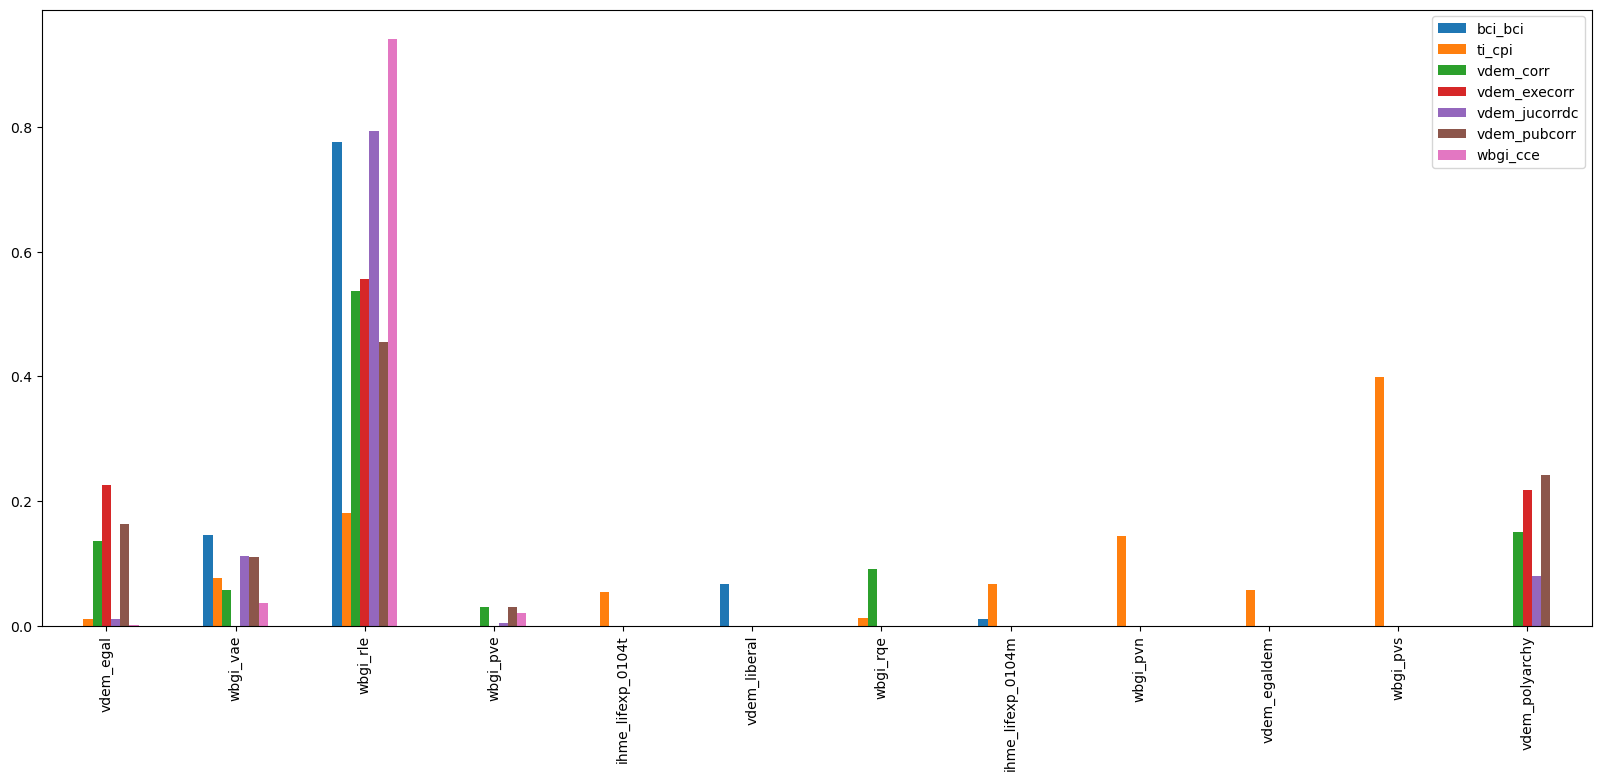

In [8]:
lasso_info_script(selected_features_dict)

use the union of all possible features for training next

scores


,r2,rmse
bci_bci,0.705055,59.955703
ti_cpi,0.477194,245.260766
vdem_corr,0.6869,0.025578
vdem_execorr,0.617321,0.031551
vdem_jucorrdc,0.452976,0.365137
vdem_pubcorr,0.690323,0.025269
wbgi_cce,0.871896,0.105505


feature importance


,ihme_lifexp_0104f,wbgi_rqe,fh_status,wbgi_vae,wbgi_rle,wbgi_pve,vdem_libdem,vdem_partipdem,vdem_egaldem,vdem_delibdem,...,ihme_lifexp_0104t,ihme_hle_0104f,fh_pr,vdem_egal,vdem_liberal,wbgi_pvs,ihme_hle_0104t,vdem_edcomp_thick,wbgi_gee,vdem_polyarchy
bci_bci,0.0,0.0,0.044512,0.0,0.366551,0.0,0.0,0.0,0.0,0.0,...,0.0,0.058579,0.0,0.0,0.0,0.050999,0.0,0.0,0.238691,0.051459
ti_cpi,0.0,0.0,0.0,0.113608,0.149626,0.021141,0.0,0.007763,0.0,0.037144,...,0.0,0.028592,0.0,0.0,0.0,0.39038,0.0,0.023529,0.0,0.0
vdem_corr,0.004784,0.045698,0.0,0.0,0.104486,0.019058,0.328329,0.086911,0.0,0.006087,...,0.011146,0.0,0.004212,0.046094,0.0,0.040746,0.0,0.0,0.141242,0.07847
vdem_execorr,0.0,0.009567,0.0,0.0,0.212938,0.013605,0.186221,0.0,0.0,0.0,...,0.0,0.0,0.0,0.112226,0.17515,0.007013,0.0,0.006076,0.188823,0.0
vdem_jucorrdc,0.013227,0.031585,0.006338,0.06837,0.069225,0.002448,0.252092,0.029142,0.0,0.051602,...,0.0,0.0,0.017263,0.013255,0.005684,0.022195,0.018164,0.07873,0.069399,0.187652
vdem_pubcorr,0.015185,0.019749,0.0,0.049098,0.123994,0.03599,0.210891,0.0,0.0,0.0,...,0.0,0.0,0.0,0.098371,0.063466,0.033496,0.0,0.001713,0.237351,0.0
wbgi_cce,0.0,0.022289,0.015201,0.02375,0.386453,0.010185,0.016435,0.0,0.011994,0.0,...,0.0,0.060479,0.0,0.0,0.0,0.044436,0.0,0.0,0.288923,0.0



feature importance rank


,ihme_lifexp_0104f,wbgi_rqe,fh_status,wbgi_vae,wbgi_rle,wbgi_pve,vdem_libdem,vdem_partipdem,vdem_egaldem,vdem_delibdem,...,ihme_lifexp_0104t,ihme_hle_0104f,fh_pr,vdem_egal,vdem_liberal,wbgi_pvs,ihme_hle_0104t,vdem_edcomp_thick,wbgi_gee,vdem_polyarchy
bci_bci,<NA>,<NA>,9,<NA>,1,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,4,<NA>,<NA>,<NA>,8,<NA>,<NA>,2,7
ti_cpi,<NA>,<NA>,<NA>,4,2,10,<NA>,11,<NA>,6,...,<NA>,8,<NA>,<NA>,<NA>,1,<NA>,9,<NA>,<NA>
vdem_corr,14,7,<NA>,<NA>,3,11,1,4,<NA>,13,...,12,<NA>,15,6,<NA>,9,<NA>,<NA>,2,5
vdem_execorr,<NA>,8,<NA>,<NA>,1,7,3,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,5,4,9,<NA>,10,2,<NA>
vdem_jucorrdc,16,9,17,6,5,19,1,10,<NA>,7,...,<NA>,<NA>,14,15,18,12,13,3,4,2
vdem_pubcorr,13,12,<NA>,7,3,8,2,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,4,5,9,<NA>,14,1,<NA>
wbgi_cce,<NA>,8,10,7,1,12,9,<NA>,11,<NA>,...,<NA>,4,<NA>,<NA>,<NA>,5,<NA>,<NA>,2,<NA>


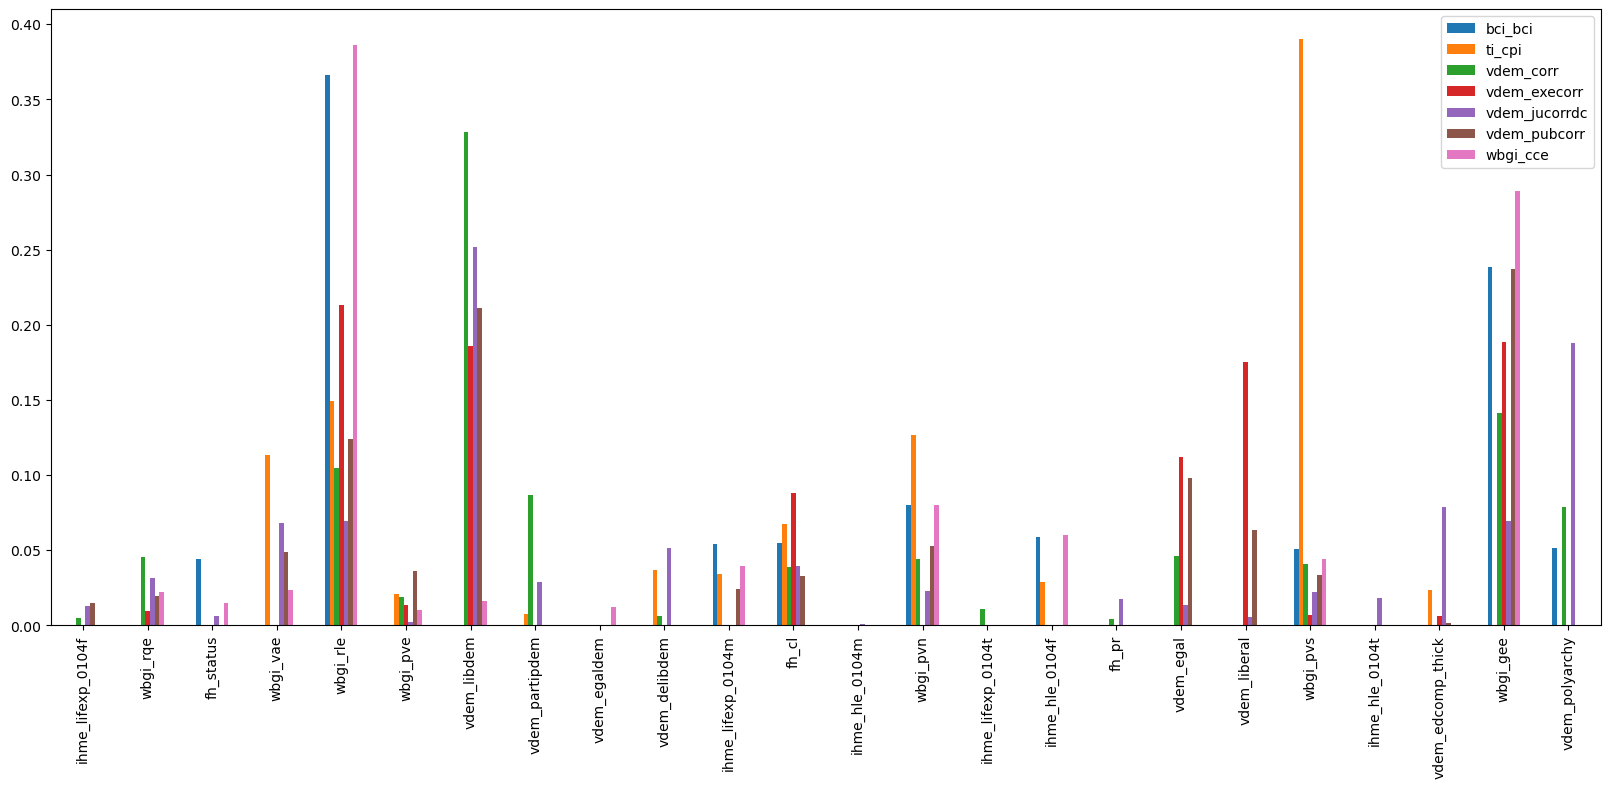

In [9]:
lasso_info_script(best_features_union)

use all common features for training

scores


,r2,rmse
bci_bci,0.641013,72.974089
ti_cpi,0.093176,425.41252
vdem_corr,0.652721,0.028371
vdem_execorr,0.602062,0.032809
vdem_jucorrdc,0.332034,0.445866
vdem_pubcorr,0.684918,0.02571
wbgi_cce,0.848403,0.124853


feature importance


,wbgi_vae,vdem_egal,wbgi_rle,wbgi_rqe
bci_bci,0.212688,0.014541,0.772771,0.0
ti_cpi,0.0,0.0,1.0,0.0
vdem_corr,0.125294,0.186267,0.58773,0.100709
vdem_execorr,0.227698,0.266767,0.505535,0.0
vdem_jucorrdc,0.205138,0.023569,0.771294,0.0
vdem_pubcorr,0.199022,0.267283,0.533694,0.0
wbgi_cce,0.037092,0.004845,0.958062,0.0



feature importance rank


,wbgi_vae,vdem_egal,wbgi_rle,wbgi_rqe
bci_bci,2,3,1,<NA>
ti_cpi,<NA>,<NA>,1,<NA>
vdem_corr,3,2,1,4
vdem_execorr,3,2,1,<NA>
vdem_jucorrdc,2,3,1,<NA>
vdem_pubcorr,3,2,1,<NA>
wbgi_cce,2,3,1,<NA>


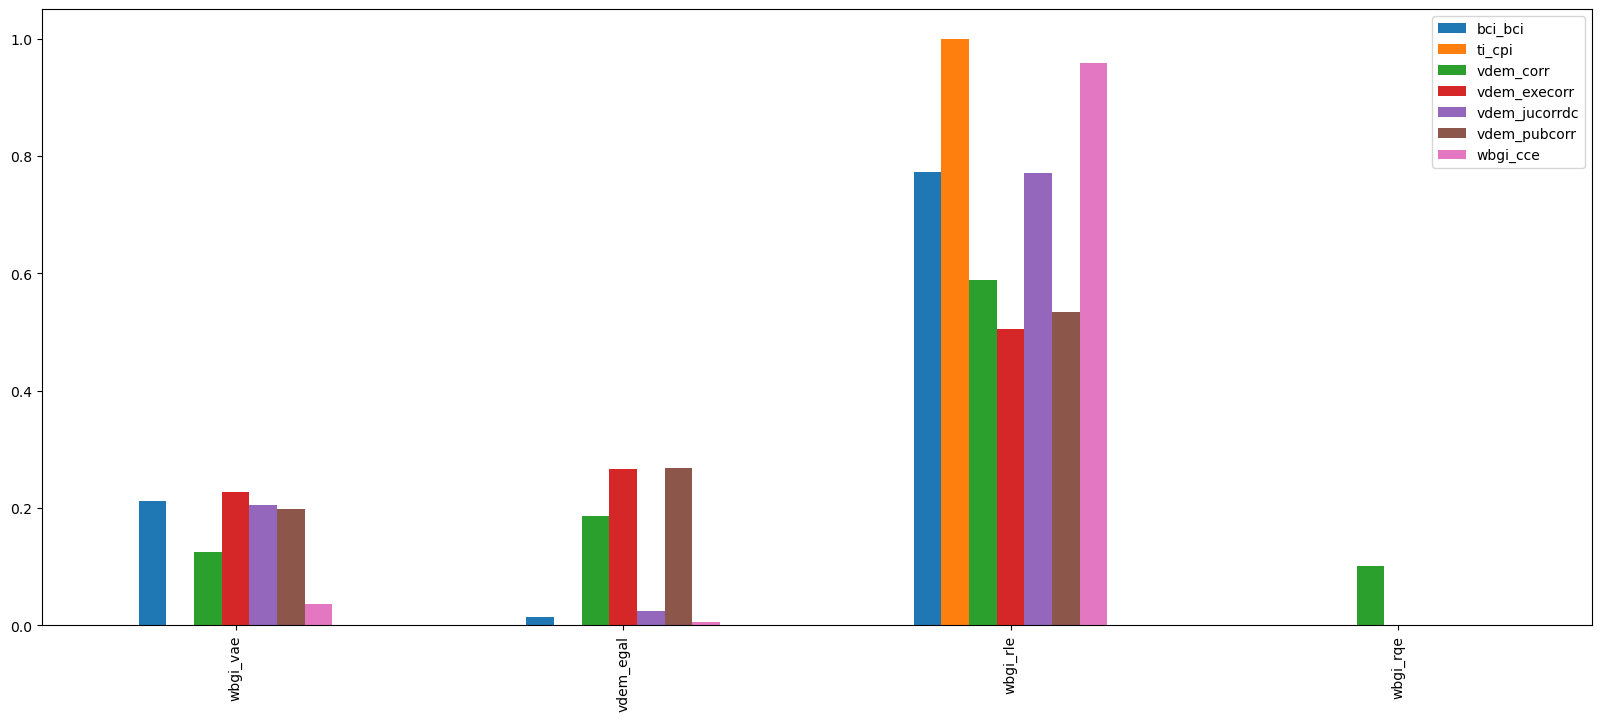

In [10]:
lasso_info_script(selected_features_intersection)

### Random Forest

In [11]:
def rf_info_script(features):
    rf_bf = dict()

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_rf(df, target, list(features[target]), fprint=False)
        else:
            rf_bf[target] = apply_rf(df, target, features, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)

    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()



use selected feature for each index

scores


,r2,rmse
bci_bci,0.637755,73.636206
ti_cpi,0.936597,29.743698
vdem_corr,0.713873,0.023375
vdem_execorr,0.592716,0.033579
vdem_jucorrdc,0.331328,0.446337
vdem_pubcorr,0.636296,0.029677
wbgi_cce,0.855793,0.118767


feature importance


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,0.023509,0.028899,0.85255,0.013229,0.009899,0.048383,0.014113,0.009418,NaN,NaN,NaN,NaN
ti_cpi,0.00972,0.005702,0.27359,NaN,0.002241,NaN,0.01222,0.002948,0.0208,0.003428,0.669351,NaN
vdem_corr,0.311905,0.080553,0.513776,0.024249,NaN,NaN,0.018444,NaN,NaN,NaN,NaN,0.051073
vdem_execorr,0.63014,0.067012,0.182346,NaN,NaN,NaN,0.039754,NaN,NaN,NaN,NaN,0.080748
vdem_jucorrdc,0.052502,0.091563,0.757634,0.023179,NaN,NaN,0.032379,NaN,NaN,NaN,NaN,0.042741
vdem_pubcorr,0.283618,0.070243,0.500132,0.015594,NaN,NaN,0.021893,NaN,NaN,NaN,NaN,0.108521
wbgi_cce,0.010234,0.013294,0.944415,0.010071,NaN,NaN,0.011011,NaN,NaN,NaN,NaN,0.010976



feature importance rank


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,4,3,1,6,7,2,5,8,<NA>,<NA>,<NA>,<NA>
ti_cpi,5,6,2,<NA>,9,<NA>,4,8,3,7,1,<NA>
vdem_corr,2,3,1,5,<NA>,<NA>,6,<NA>,<NA>,<NA>,<NA>,4
vdem_execorr,1,4,2,<NA>,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,3
vdem_jucorrdc,3,2,1,6,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,4
vdem_pubcorr,2,4,1,6,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,3
wbgi_cce,5,2,1,6,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,4


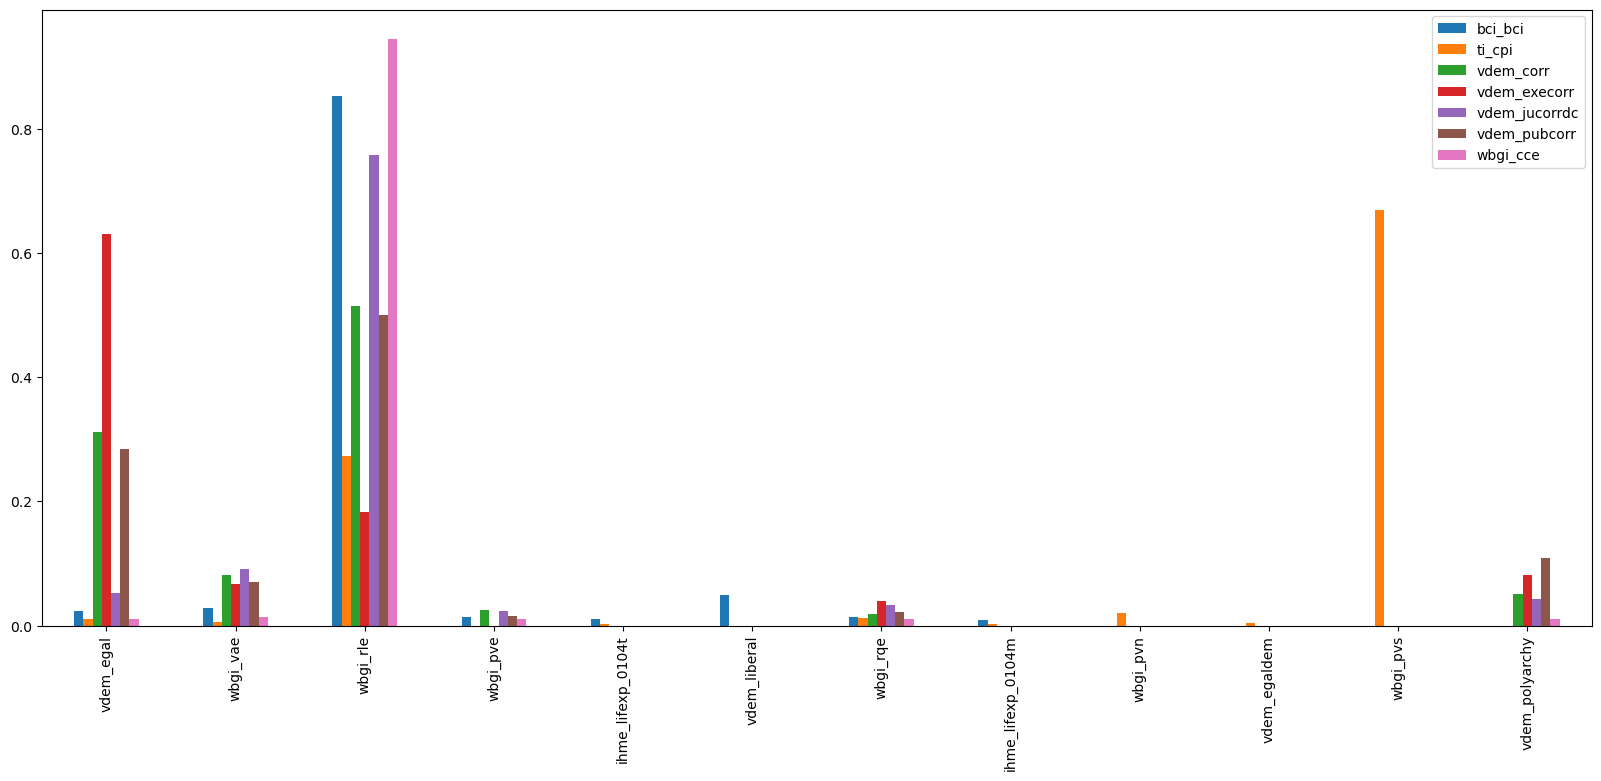

In [12]:
rf_info_script(selected_features_dict)

use the union of all "possible" features for all target

scores


,r2,rmse
bci_bci,0.677519,65.553225
ti_cpi,0.941079,27.641323
vdem_corr,0.66399,0.02745
vdem_execorr,0.634921,0.0301
vdem_jucorrdc,0.32746,0.448919
vdem_pubcorr,0.645517,0.028925
wbgi_cce,0.865697,0.11061


feature importance


,ihme_lifexp_0104f,wbgi_rqe,fh_status,wbgi_vae,wbgi_rle,wbgi_pve,vdem_libdem,vdem_partipdem,vdem_egaldem,vdem_delibdem,...,ihme_lifexp_0104t,ihme_hle_0104f,fh_pr,vdem_egal,vdem_liberal,wbgi_pvs,ihme_hle_0104t,vdem_edcomp_thick,wbgi_gee,vdem_polyarchy
bci_bci,0.003545,0.006917,0.001109,0.007481,0.489494,0.007037,0.01966,0.009991,0.006165,0.008364,...,0.001998,0.005186,0.001503,0.01038,0.010657,0.002377,0.002102,0.005701,0.365126,0.023733
ti_cpi,0.000958,0.009722,0.000194,0.003387,0.267494,0.006292,0.001029,0.002465,0.001676,0.001747,...,0.000702,0.000821,0.000305,0.004586,0.00134,0.664926,0.001189,0.001667,0.007517,0.001083
vdem_corr,0.003623,0.006542,0.000261,0.017821,0.43293,0.014551,0.062306,0.006481,0.007443,0.005429,...,0.002155,0.005156,0.001308,0.268861,0.104441,0.001916,0.002716,0.010448,0.026185,0.007555
vdem_execorr,0.00302,0.009709,0.000568,0.01336,0.097456,0.012977,0.091754,0.010452,0.014869,0.016249,...,0.002394,0.003989,0.002263,0.468148,0.167088,0.003544,0.002851,0.013759,0.042988,0.00793
vdem_jucorrdc,0.004267,0.007542,0.000374,0.04259,0.684044,0.011564,0.011869,0.009078,0.006987,0.007142,...,0.003838,0.005095,0.001312,0.021987,0.113584,0.002062,0.004139,0.012823,0.027103,0.006174
vdem_pubcorr,0.003378,0.006768,0.00046,0.0042,0.263078,0.015299,0.112022,0.006268,0.167776,0.004722,...,0.00191,0.005627,0.001478,0.168792,0.057507,0.002783,0.001915,0.008056,0.152381,0.007001
wbgi_cce,0.001574,0.00509,0.000131,0.005858,0.874666,0.006495,0.002494,0.00229,0.002554,0.001535,...,0.000938,0.002075,0.000521,0.004499,0.002813,0.002102,0.000911,0.002333,0.074388,0.002032



feature importance rank


,ihme_lifexp_0104f,wbgi_rqe,fh_status,wbgi_vae,wbgi_rle,wbgi_pve,vdem_libdem,vdem_partipdem,vdem_egaldem,vdem_delibdem,...,ihme_lifexp_0104t,ihme_hle_0104f,fh_pr,vdem_egal,vdem_liberal,wbgi_pvs,ihme_hle_0104t,vdem_edcomp_thick,wbgi_gee,vdem_polyarchy
bci_bci,16,11,24,9,1,10,4,7,12,8,...,22,14,23,6,5,19,20,13,2,3
ti_cpi,19,4,24,8,2,6,17,9,12,11,...,21,20,23,7,14,1,15,13,5,16
vdem_corr,17,11,24,6,1,7,4,12,10,14,...,19,15,22,2,3,20,18,8,5,9
vdem_execorr,18,12,24,9,3,10,4,11,7,6,...,21,16,22,1,2,17,19,8,5,13
vdem_jucorrdc,17,10,24,3,1,8,7,9,12,11,...,19,16,23,5,2,21,18,6,4,14
vdem_pubcorr,15,10,24,14,1,7,5,11,3,13,...,20,12,21,2,6,17,19,8,4,9
wbgi_cce,16,5,24,4,1,3,9,11,8,17,...,20,13,23,6,7,12,21,10,2,14


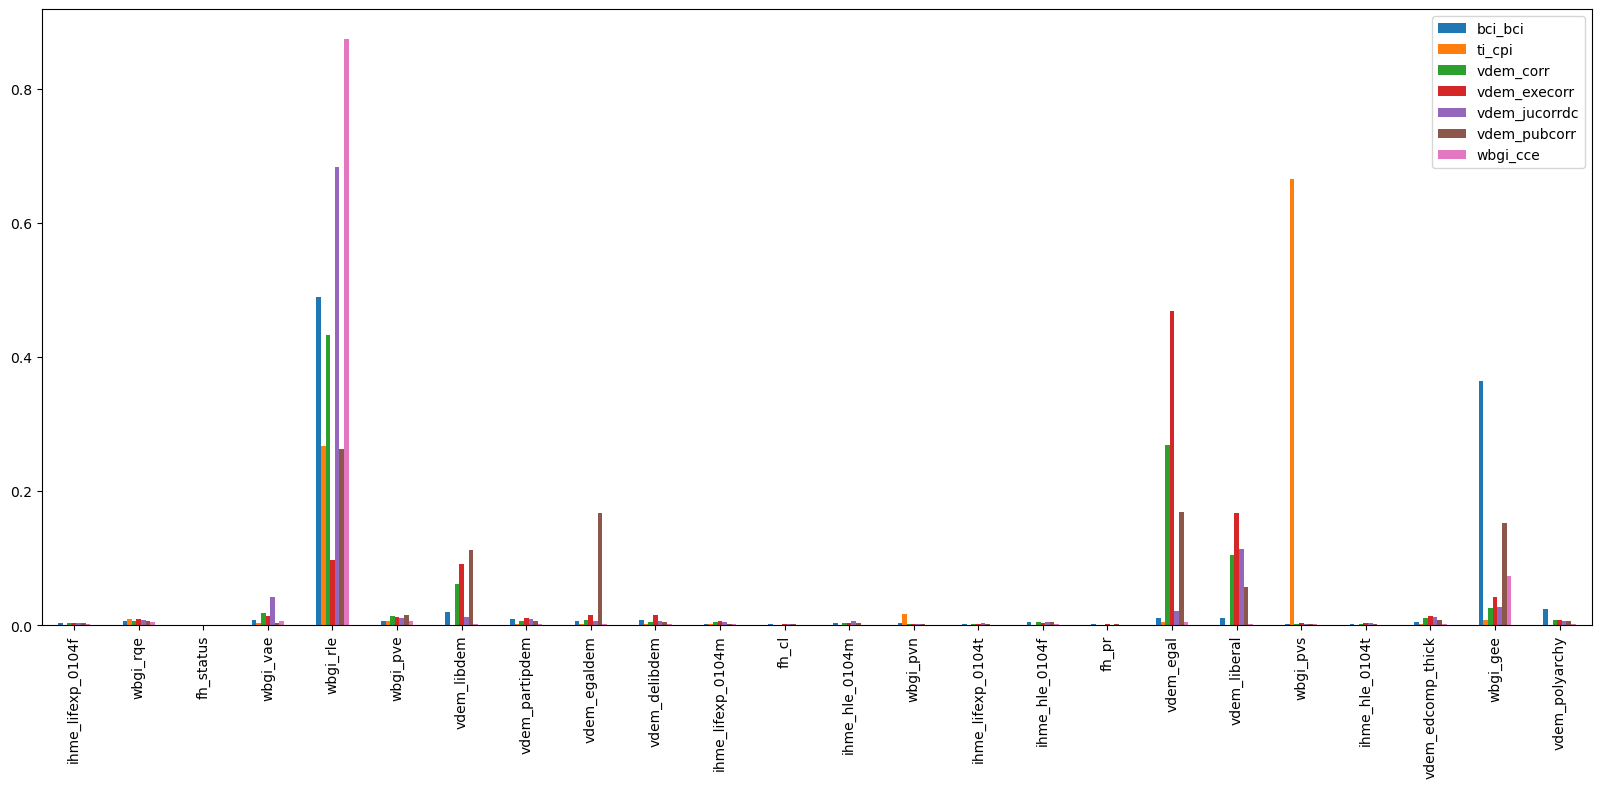

In [13]:
rf_info_script(best_features_union)

use the smalles set of common features

scores


,r2,rmse
bci_bci,0.633633,74.474267
ti_cpi,-0.069055,501.51882
vdem_corr,0.652558,0.028384
vdem_execorr,0.576189,0.034942
vdem_jucorrdc,0.282696,0.478799
vdem_pubcorr,0.618101,0.031162
wbgi_cce,0.838128,0.133316


feature importance


,wbgi_vae,vdem_egal,wbgi_rle,wbgi_rqe
bci_bci,0.067202,0.041253,0.865379,0.026165
ti_cpi,0.217659,0.210623,0.326304,0.245415
vdem_corr,0.109888,0.330309,0.529774,0.030029
vdem_execorr,0.09752,0.652595,0.197314,0.052571
vdem_jucorrdc,0.113164,0.070289,0.772703,0.043844
vdem_pubcorr,0.123585,0.324097,0.516622,0.035696
wbgi_cce,0.019992,0.01652,0.948873,0.014615



feature importance rank


,wbgi_vae,vdem_egal,wbgi_rle,wbgi_rqe
bci_bci,2,3,1,4
ti_cpi,3,4,1,2
vdem_corr,3,2,1,4
vdem_execorr,3,1,2,4
vdem_jucorrdc,2,3,1,4
vdem_pubcorr,3,2,1,4
wbgi_cce,2,3,1,4


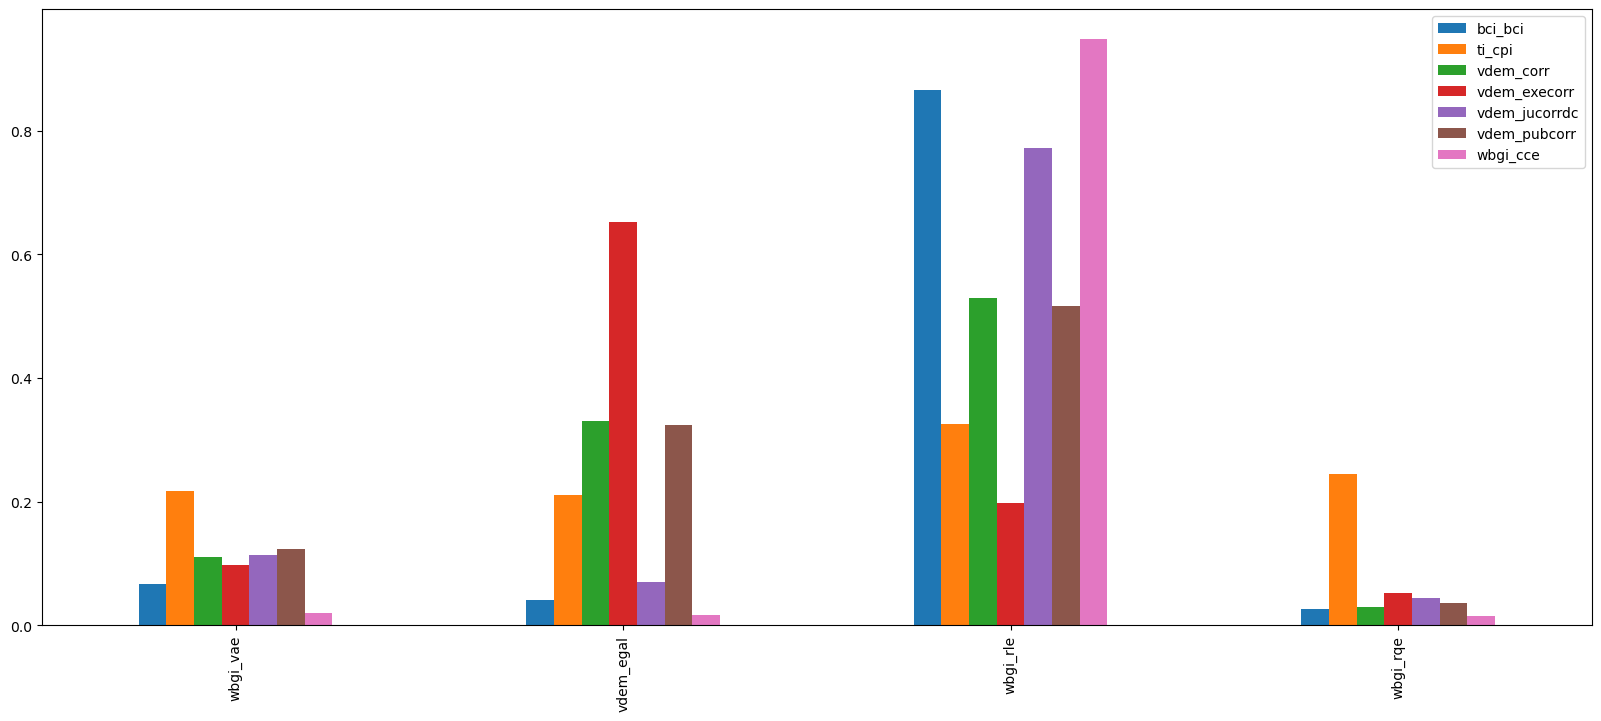

In [14]:
rf_info_script(selected_features_intersection)

### Grid Search Random Forest

In [19]:
def rf_gridsearch_info_script(features):
    rf_bf = dict()

    param_grid = {
        "randomforestregressor__max_depth": [2, 3, 5, 10, None],
        "randomforestregressor__min_samples_split": [2, 3, 5, 10],
        "randomforestregressor__max_features": ["log2", None]
        }

    df_score = pd.DataFrame(columns=['r2', 'rmse'], index=corr_cols)
    for target in corr_cols:
        if isinstance(features, dict):
            rf_bf[target] = apply_gridsearch_rf(df, target, list(features[target]), param_grid, fprint=False)
        else:
            rf_bf[target] = apply_gridsearch_rf(df, target, features, param_grid, fprint=False)
        df_score.loc[target,] = [rf_bf[target]['r2'] ,rf_bf[target]['rmse']]
    
    print('scores')
    display(df_score)

    l_fi = [rf_bf[target]['feat_importance'] for target in corr_cols]
    df_fi = pd.concat(l_fi)
    rf_bf[target]
    l_firk = [rf_bf[target]['feat_importance_rank'] for target in corr_cols]
    df_firk = pd.concat(l_firk)
    rf_bf[target]['params']
    l_params = [rf_bf[target]['params'] for target in corr_cols]
    df_params = pd.concat(l_params)

    print('feature importance')
    display(df_fi)

    df_fi.T.plot(kind='bar', figsize=(20,8))
    print()

    print('feature importance rank')
    display(df_firk)
    print()

    print('params')
    display(df_params)
    print()


scores


,r2,rmse
bci_bci,0.655322,70.065358
ti_cpi,0.934765,30.603316
vdem_corr,0.724215,0.02253
vdem_execorr,0.611862,0.032001
vdem_jucorrdc,0.397223,0.402352
vdem_pubcorr,0.667846,0.027103
wbgi_cce,0.883206,0.09619


feature importance


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,0.011189,0.019949,0.918438,0.004002,0.002248,0.038023,0.00366,0.002492,NaN,NaN,NaN,NaN
ti_cpi,0.009966,0.005666,0.273863,NaN,0.002146,NaN,0.01202,0.002956,0.020483,0.003236,0.669664,NaN
vdem_corr,0.282843,0.165669,0.300471,0.033468,NaN,NaN,0.107337,NaN,NaN,NaN,NaN,0.110213
vdem_execorr,0.331714,0.263553,0.17486,NaN,NaN,NaN,0.069774,NaN,NaN,NaN,NaN,0.1601
vdem_jucorrdc,0.10795,0.235063,0.343057,0.022937,NaN,NaN,0.210097,NaN,NaN,NaN,NaN,0.080896
vdem_pubcorr,0.276104,0.127311,0.277057,0.027489,NaN,NaN,0.101355,NaN,NaN,NaN,NaN,0.190684
wbgi_cce,0.100474,0.164235,0.363864,0.101333,NaN,NaN,0.255625,NaN,NaN,NaN,NaN,0.014469



feature importance rank


,vdem_egal,wbgi_vae,wbgi_rle,wbgi_pve,ihme_lifexp_0104t,vdem_liberal,wbgi_rqe,ihme_lifexp_0104m,wbgi_pvn,vdem_egaldem,wbgi_pvs,vdem_polyarchy
bci_bci,4,3,1,5,8,2,6,7,<NA>,<NA>,<NA>,<NA>
ti_cpi,5,6,2,<NA>,9,<NA>,4,8,3,7,1,<NA>
vdem_corr,2,3,1,6,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,4
vdem_execorr,1,2,3,<NA>,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,4
vdem_jucorrdc,4,2,1,6,<NA>,<NA>,3,<NA>,<NA>,<NA>,<NA>,5
vdem_pubcorr,2,4,1,6,<NA>,<NA>,5,<NA>,<NA>,<NA>,<NA>,3
wbgi_cce,5,3,1,4,<NA>,<NA>,2,<NA>,<NA>,<NA>,<NA>,6



params


,randomforestregressor__max_depth,randomforestregressor__max_features,randomforestregressor__min_samples_split
bci_bci,5,None,10
ti_cpi,None,None,3
vdem_corr,10,log2,2
vdem_execorr,3,log2,2
vdem_jucorrdc,5,log2,10
vdem_pubcorr,10,log2,3
wbgi_cce,10,log2,2


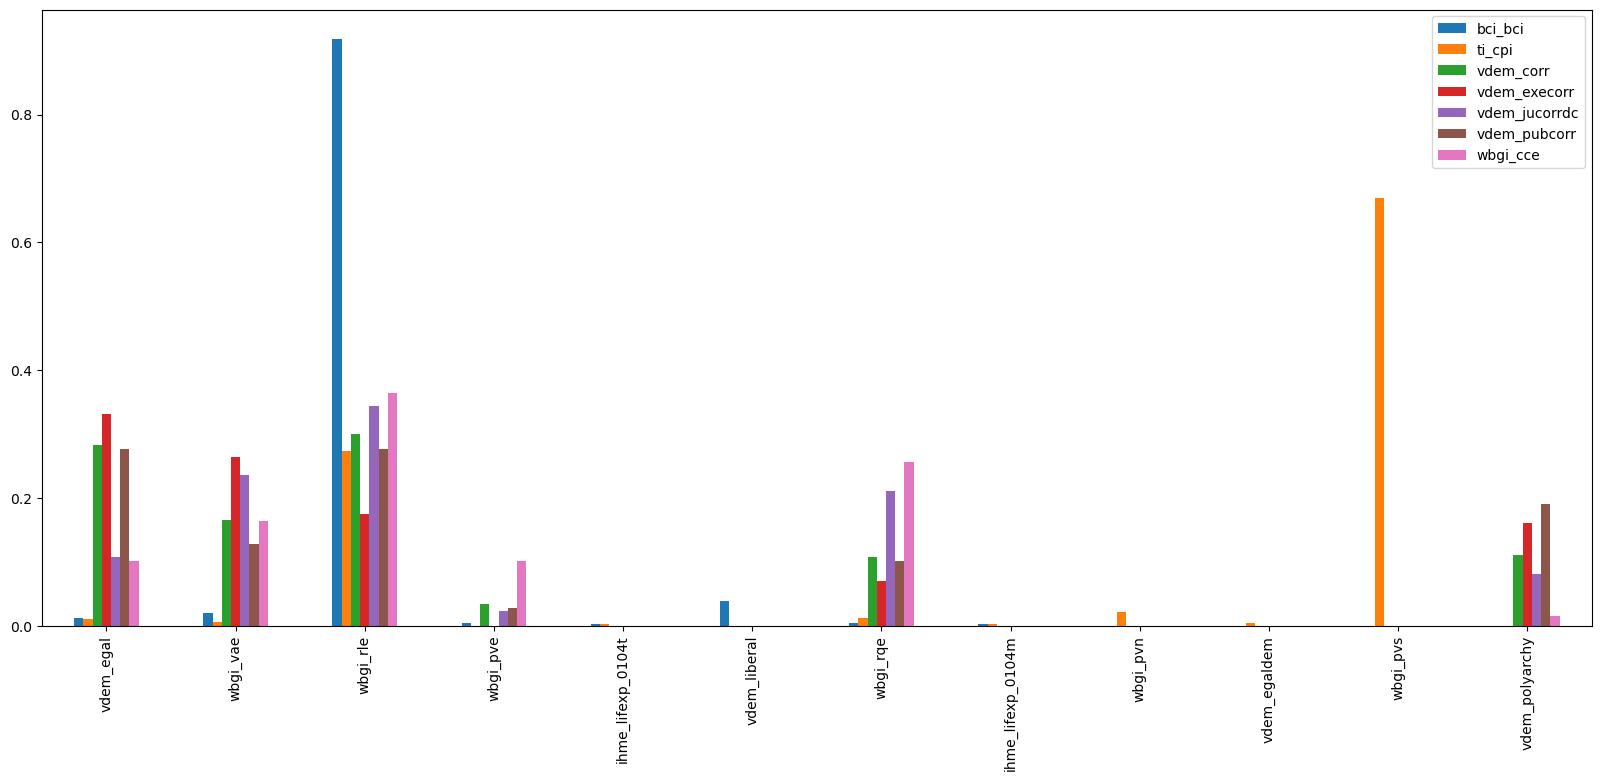

In [20]:
rf_gridsearch_info_script(selected_features_dict)